Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [4]:
# -.-|m { input: false }

!pip install -r ../requirements.txt


  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)


In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison, HeightPredictor
import preprocessing as pp

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [23]:
!git lfs pull

In [2]:

import os


DATA_DIR = '.'

path_data_NLD = os.path.join(DATA_DIR, 'df-NLD-exp.pkl')
path_data_FRA = os.path.join(DATA_DIR, 'df-FRA-exp.pkl')
path_data_ESP = os.path.join(DATA_DIR, 'df-ESP-exp.pkl')

df = pd.read_pickle(path_data_ESP)


In [ ]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# sf = shp.Reader("C:/Users/utente/Downloads/gadm41_ESP_shp/gadm41_ESP_3.shp")

#plt.figure()
#for shape in sf.shapeRecords():
#    x = [i[0] for i in shape.shape.points[:]]
#    y = [i[1] for i in shape.shape.points[:]]

fig, ax = plt.subplots(figsize=(16, 16))

#sf = gpd.read_file("C:/Users/utente/Downloads/gadm41_ITA_shp/gadm41_ITA_3.shp")
#sf.plot(ax = ax)

#for i in range(20000):
df = gpd.read_file("C:/Users/utente/Documents/map2324-1.gpkg", #  where="age!=''", 
                       #rows = slice(0,1000000),  
                       engine='pyogrio', use_arrow=True
                       )
#df_ll = df[['age', 'geometry']]
df_ll = df.to_crs({'init': 'epsg:4326'}) 
df_ll.plot(ax  = ax, color = "black")

age_true = [not item for item in pd.isna(df_ll['age'])]

df_ll[age_true].plot(ax  = ax, color = "red")
#print(age_true[1])
#print(len(df_ll))
#age_true.sum()
#print(len(df_ll)- age_true.sum())
print(len(df_ll[age_true]))
print(len(df_ll[age_true])/len(df_ll))
print(len(df_ll))

#df_ll = df_ll[['age', 'geometry']]
#df.iloc[::100, :]
# _=ax.axis('off')
# plt.show()


45871
0.03319487361329213
1381870


<Axes: >

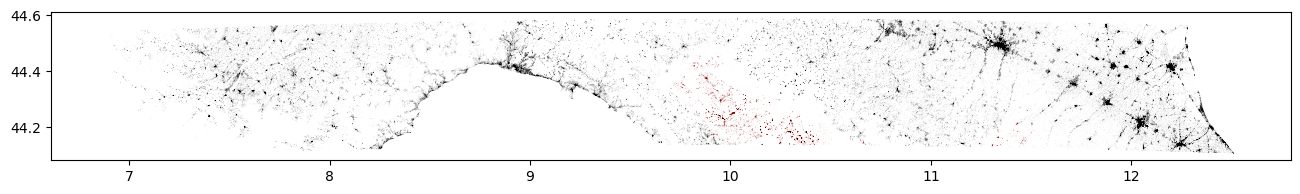

In [5]:
#age_true = 
age_true = [not item for item in pd.isna(df_ll['age'])]
#print(age_true[1])
#print(len(df_ll))
#age_true.sum()
#print(len(df_ll)- age_true.sum())
print(len(df_ll[age_true]))
print(len(df_ll[age_true])/len(df_ll))
print(len(df_ll))

fig, ax = plt.subplots(figsize=(16, 16))
df_ll.plot(ax  = ax, color = "black")
df_ll[age_true].plot(ax  = ax, color = "red")
# for i in range(len(age_true)):
#     if(age_true[i]): 
#         df_ll.loc[i]
       #print(df_ll[i])
#df_ll.loc[age_true]
#df_ll.head()


Get more data from EUBUCCO

In [ ]:
import requests
import urllib.parse

root_url = "https://api.eubucco.com"
api_url = "/v0.1/countries"

#print(urllib.parse.urljoin(root_url, api_url))

response = requests.get(urllib.parse.urljoin(root_url, api_url))
response.json()

# parsing json blablabla



In [ ]:
gpd.read_file("C:/Users/utente/ufo-prediction/metadata/v0_1-CYP.gpkg/v0_1-CYP.gpkg")

## Prediction

In [3]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Failed to calculate energy error: ['residential_type']


MAE: 11.47 y
RMSE: 15.45 y
R2: 0.4393
R2: nan
MAPE: nan


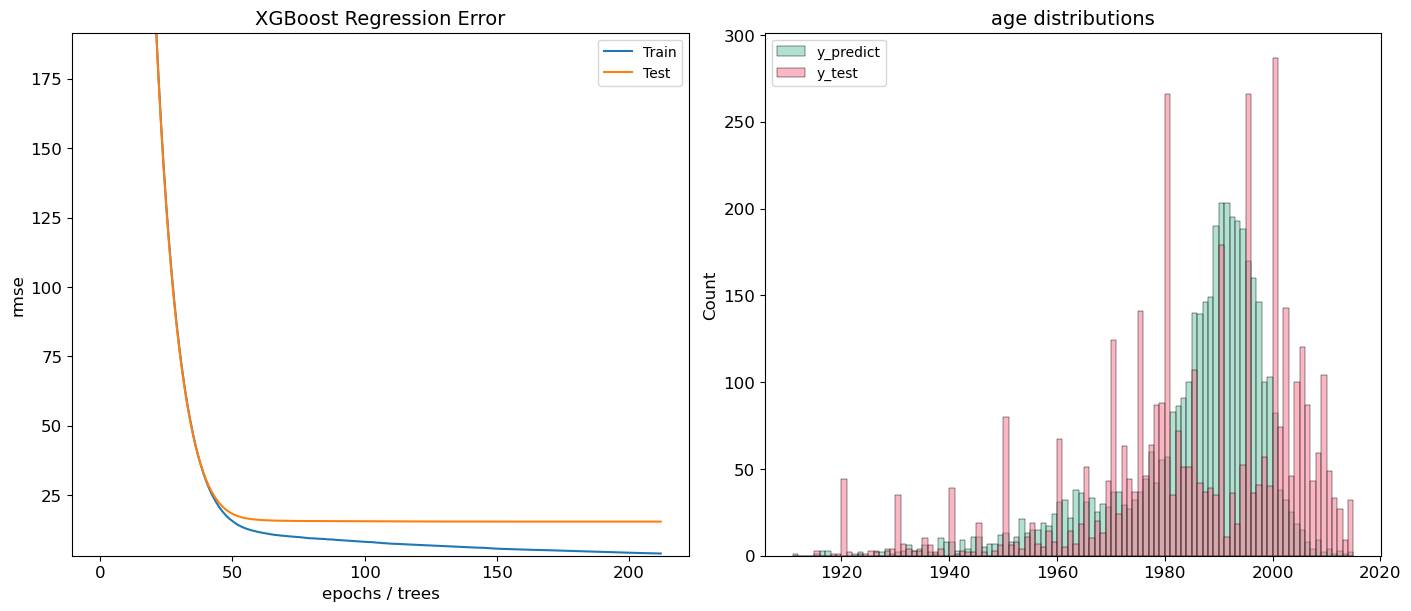

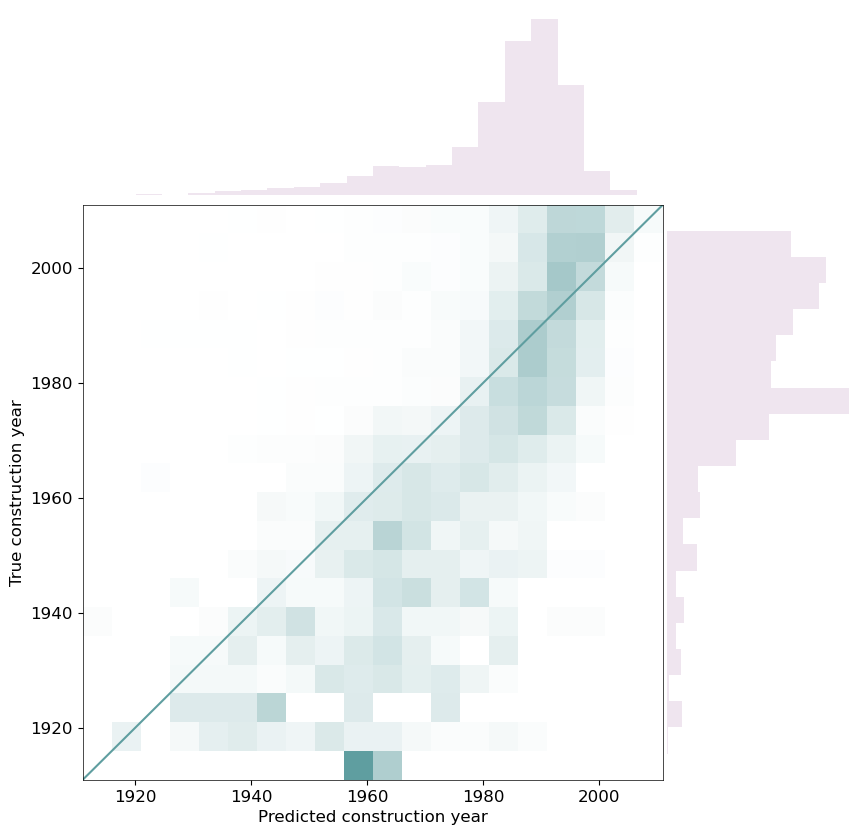

In [5]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


### Classification

In [9]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    bin_config=equally_sized_bins,
    #bins=tabula_nl_bins,
)
classifier.evaluate()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


KeyboardInterrupt: 

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [34]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [35]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725
